<a href="https://colab.research.google.com/github/LucasGarrett36/Disciplina13Unidade4/blob/main/ATV2%2C_este_%C3%A9_o_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dados salvos em bitcoin_prices.csv

📊 Estatísticas Básicas dos Preços:
count       181.000000
mean      85947.513126
std       15398.116194
min       57381.764445
25%       68388.871290
50%       94217.022296
75%       97679.463816
max      106182.236820
Name: price, dtype: float64 



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[21:19:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




🎯 Acurácia do Random Forest: 97.22%
🎯 Acurácia do XGBoost: 97.22%



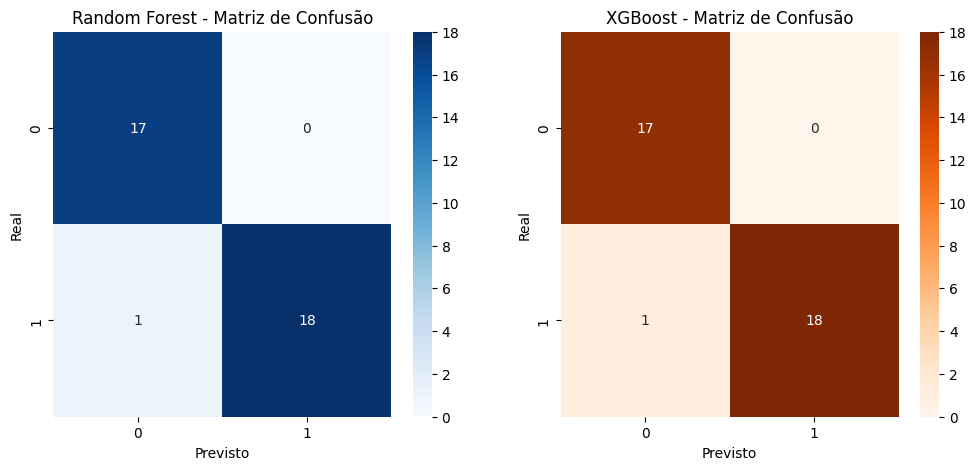

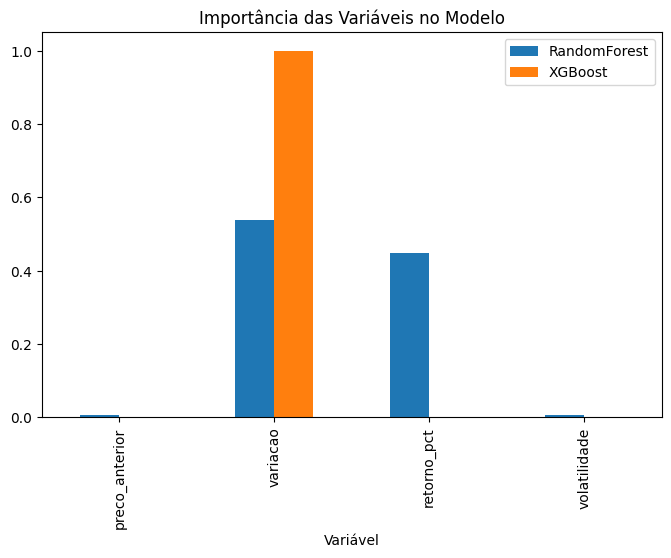


🔍 Relatório de Classificação - Random Forest
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.95      0.97        19

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36


🔍 Relatório de Classificação - XGBoost
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.95      0.97        19

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



In [4]:
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def fetch_crypto_data(crypto_id="bitcoin", currency="usd", days=180):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
    params = {"vs_currency": currency, "days": days, "interval": "daily"}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])

        df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.drop("timestamp", axis=1, inplace=True)

        return df
    else:
        print("Erro ao buscar os dados:", response.status_code)
        return None

df = fetch_crypto_data(days=180)

if df is not None:

    df.to_csv("bitcoin_prices.csv", index=False)
    print("✅ Dados salvos em bitcoin_prices.csv\n")

    print("📊 Estatísticas Básicas dos Preços:")
    print(df["price"].describe(), "\n")

    fig = px.line(df, x="date", y="price", title="Preço Histórico do Bitcoin (Últimos 180 dias)")
    fig.show()

    df["preco_anterior"] = df["price"].shift(1)
    df["variacao"] = df["price"] - df["preco_anterior"]
    df["retorno_pct"] = df["variacao"] / df["preco_anterior"] * 100
    df["volatilidade"] = df["retorno_pct"].rolling(window=5).std()

    df["subiu"] = (df["price"] > df["preco_anterior"]).astype(int)

    df.dropna(inplace=True)

    X = df[["preco_anterior", "variacao", "retorno_pct", "volatilidade"]]
    y = df["subiu"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)

    rf_acc = accuracy_score(y_test, rf_pred)
    xgb_acc = accuracy_score(y_test, xgb_pred)

    print(f"🎯 Acurácia do Random Forest: {rf_acc:.2%}")
    print(f"🎯 Acurácia do XGBoost: {xgb_acc:.2%}\n")

    cm_rf = confusion_matrix(y_test, rf_pred)
    cm_xgb = confusion_matrix(y_test, xgb_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Random Forest - Matriz de Confusão")
    axes[0].set_xlabel("Previsto")
    axes[0].set_ylabel("Real")

    sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
    axes[1].set_title("XGBoost - Matriz de Confusão")
    axes[1].set_xlabel("Previsto")
    axes[1].set_ylabel("Real")

    plt.show()

    rf_importance = rf_model.feature_importances_
    xgb_importance = xgb_model.feature_importances_

    df_importance = pd.DataFrame({"Variável": X.columns,
                                  "RandomForest": rf_importance,
                                  "XGBoost": xgb_importance})

    df_importance.set_index("Variável", inplace=True)
    df_importance.plot(kind="bar", figsize=(8, 5), title="Importância das Variáveis no Modelo")
    plt.show()

    print("\n🔍 Relatório de Classificação - Random Forest")
    print(classification_report(y_test, rf_pred))

    print("\n🔍 Relatório de Classificação - XGBoost")
    print(classification_report(y_test, xgb_pred))

else:
    print("❌ Não foi possível obter os dados.")


